## QOSF Mentorship Program

### Task 3

Generate a Quantum Support Vector Machine (QSVM) using the iris dataset and try to propose a kernel from a parametric quantum circuit to classify the three classes (setosa, versicolor, virginica) using the one-vs-all format, the kernel only works as binary classification. 

Identify the proposal with the lowest number of qubits and depth to obtain higher accuracy. 

You can use the UU† format or using the Swap-Test.

In [24]:
from IPython import display

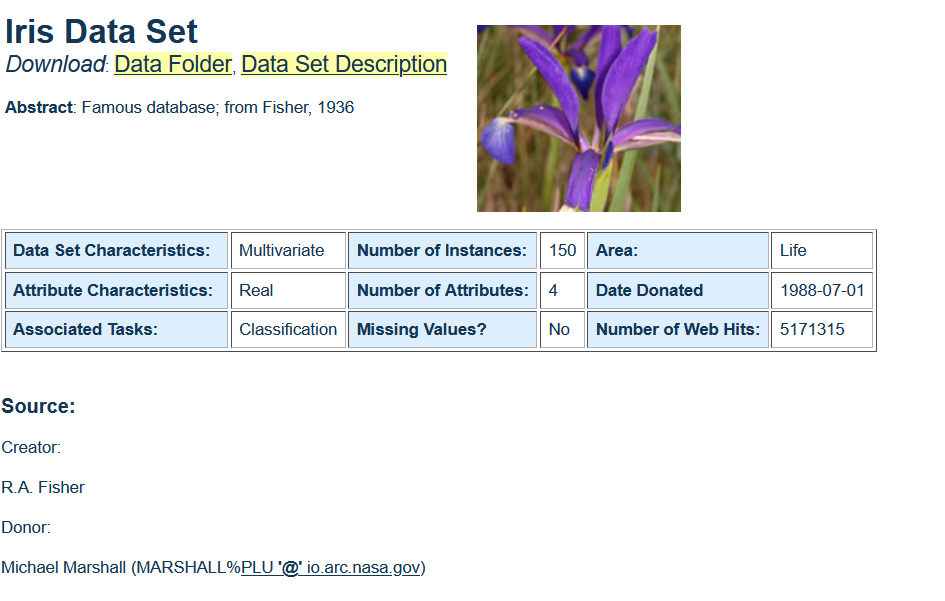

In [25]:
display.Image(r'Screenshot 2023-02-19 204909.png')

### Exploratory Data Analysis

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris

In [27]:
iris = load_iris()

In [28]:
col1 = ['sepal_length', 'sepal_width',
           'petal_length', 'petal_width']


In [29]:
df = pd.DataFrame(iris.data, columns=col1)

In [30]:
df['class'] = iris.target

In [31]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [32]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width,class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [33]:
df['class'].value_counts()

0    50
1    50
2    50
Name: class, dtype: int64

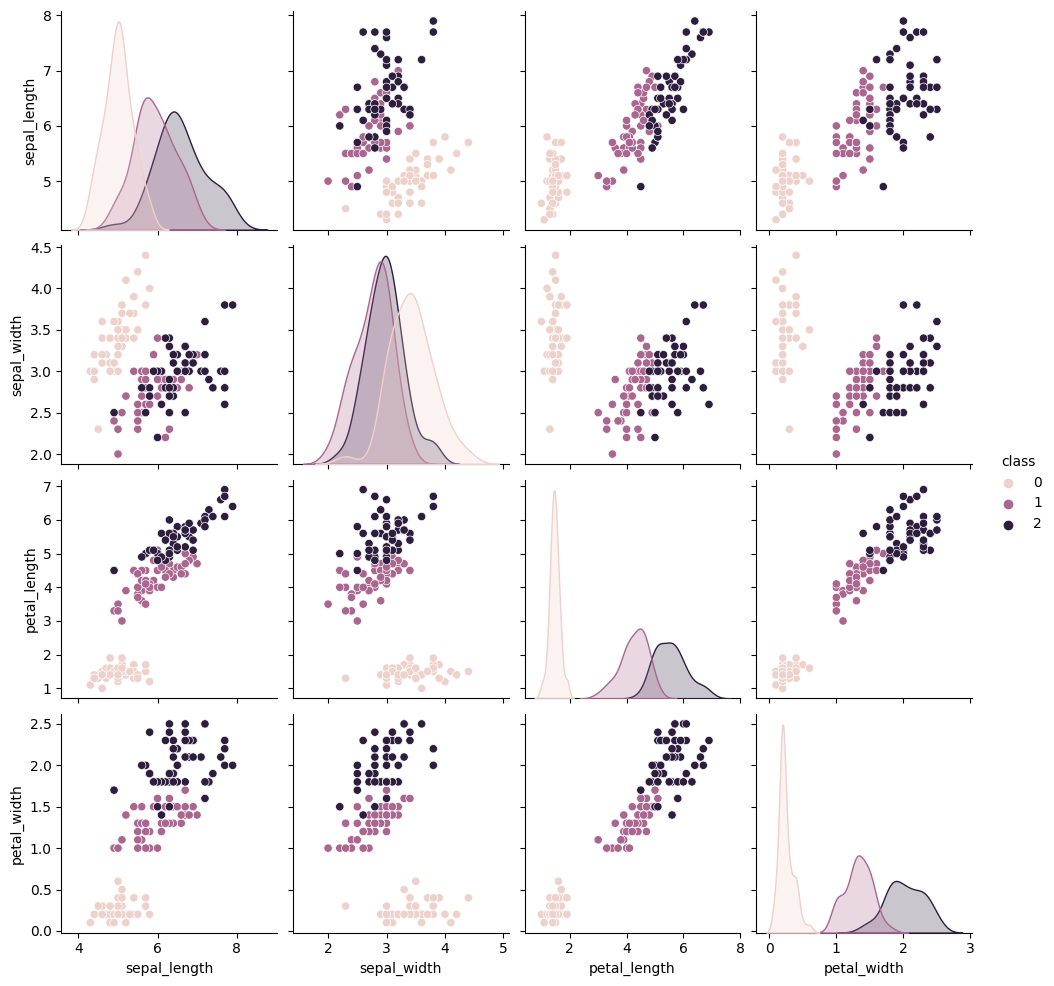

In [34]:
sns.pairplot(df, hue='class')
plt.show()

In [35]:
data = df.values
X = data[:,0:4]
Y = data[:,4]

In [36]:
Y_Data = np.array([np.average(X[:, i][Y == j].astype('float32')) for i in range(X.shape[1])
                   for j in (np.unique(Y))])
Y_Data_reshaped = Y_Data.reshape(4, 3)
Y_Data_reshaped = np.swapaxes(Y_Data_reshaped, 0, 1)
X_axis = np.arange(len(col1))
width = 0.25


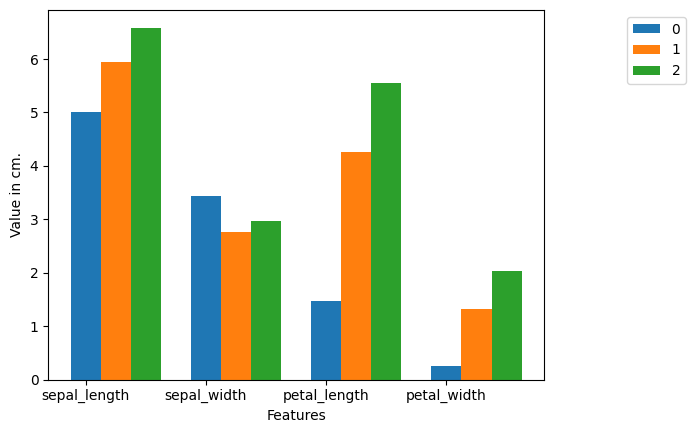

In [37]:
plt.bar(X_axis, Y_Data_reshaped[0], width, label='0')
plt.bar(X_axis+width, Y_Data_reshaped[1], width, label='1')
plt.bar(X_axis+width*2, Y_Data_reshaped[2], width, label='2')
plt.xticks(X_axis, col1[:4])
plt.xlabel("Features")
plt.ylabel("Value in cm.")
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()


## Classical Classification

We are going to use a Support Vector Classifier to classify the labels

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split

Dataset Splitting

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [40]:
svn = SVC()
svn.fit(X_train, y_train)

SVC()

In [41]:
predictions = svn.predict(X_test)
accuracy_score(y_test, predictions)

0.9666666666666667

In [42]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      0.92      0.96        12
         2.0       0.83      1.00      0.91         5

    accuracy                           0.97        30
   macro avg       0.94      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



## Quantum Kernel Machine Learning

In quantum kernel machine learning, a quantum feature map
is used to map a classical feature vector
to a quantum Hilbert space.  See "Supervised learning with quantum enhanced feature spaces" for more details.

In [43]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC

from qiskit import BasicAer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel


seed = 12345
algorithm_globals.random_seed = seed


In [44]:
data = iris.data
labels = iris.target

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [46]:
feature_map = EfficientSU2(num_qubits=1, reps=1, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)


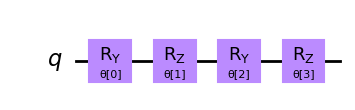

In [47]:
feature_map.decompose().draw('mpl')

In [48]:
feature_map.depth()*feature_map.width()

1

In [49]:
svc = SVC(kernel=kernel.evaluate)
svc.fit(X_train, y_train)
score = svc.score(X_test, y_test)

print(f"Callable kernel classification test score: {score}")

Callable kernel classification test score: 0.9


In [50]:
matrix_train = kernel.evaluate(x_vec=X_train)
matrix_test = kernel.evaluate(x_vec=X_test, y_vec=X_train)

svc = SVC(kernel="precomputed")
svc.fit(matrix_train, y_train)
score = svc.score(matrix_test, y_test)

print(f"Precomputed kernel classification test score: {score}")

Precomputed kernel classification test score: 0.9


In [51]:
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(X_train, y_train)
qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.9


In [52]:
predictions = qsvc.predict(X_test)

In [53]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.82      0.90      0.86        10
           2       0.92      0.92      0.92        13

    accuracy                           0.90        30
   macro avg       0.91      0.89      0.90        30
weighted avg       0.91      0.90      0.90        30



## Quantum Kernel Training & Quantum Kernel Alignment (QKA) 

QKA is a technique that iteratively adapts a parametrized quantum kernel to a dataset while converging to the maximum SVM margin. More information about QKA can be found in the preprint, “Covariant quantum kernels for data with group structure.”

In [54]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC

In [55]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

Trainable parameters: phi, ['phi[0]']


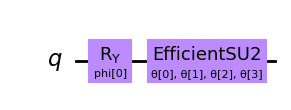

In [56]:
training_params = ParameterVector("phi", 1)
fm0 = QuantumCircuit(1)
fm0.ry(training_params[0], 0)


fm1 = EfficientSU2(num_qubits=1, reps=1, entanglement="linear")

fm = fm0.compose(fm1)

print(f"Trainable parameters: {training_params}")
fm.draw('mpl')

In [57]:
fm.depth()*fm.width()

2

In [58]:
quant_kernel = TrainableFidelityQuantumKernel(
    feature_map=fm, training_parameters=training_params)

cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback,
                learning_rate=0.05, perturbation=0.05)

qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)


In [59]:
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)


{   'optimal_circuit': None,
    'optimal_parameters': {ParameterVectorElement(phi[0]): 2.031721747986411},
    'optimal_point': array([2.03172175]),
    'optimal_value': 0.8561923899619801,
    'optimizer_evals': 30,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x000001899DCE16F0>}


In [60]:
qsvc = QSVC(quantum_kernel=optimized_kernel)

qsvc.fit(X_train, y_train)

labels_test = qsvc.predict(X_test)

accuracy_test = balanced_accuracy_score(
    y_true=y_test, y_pred=labels_test)
 
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.9666666666666667


In [61]:
print(classification_report(y_test, labels_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.90      0.95        10
           2       0.93      1.00      0.96        13

    accuracy                           0.97        30
   macro avg       0.98      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Comparison among methods

- SVC accuracy score: 0.967
- QSVC accuracy score: 0.900
- QKA accuracy score: 0.966

## References

1 - https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html

2 - https://qiskit.org/documentation/machine-learning/tutorials/08_quantum_kernel_trainer.html